## Code for spike sorting
### For single shank recordings

we first need to find the recording experiment directory, then we can load and concatenate the recordings yousin spike interface or find binary files from different experiment in one dey and merge them together then loade them into 

In [72]:
import os
import spikeinterface.full as si
print(f"SpikeInterface version: {si.__version__}")
import spikeinterface.core as sic
import spikeinterface.curation as sc
import spikeinterface.widgets as sw

import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import os
import pandas as pd
import warnings
warnings.simplefilter("ignore")
import datetime
import time

%matplotlib widget
# %matplotlib inline

job_kwargs = dict(n_jobs=32, chunk_duration='5s', progress_bar=True) ## change the number of jobs based on your cpu cores and chunk duration based on your RAM
si.set_global_job_kwargs(**job_kwargs)

SpikeInterface version: 0.103.1


## 📁 Recording Setup and Probe Configuration Summary

This section prepares the raw electrophysiology data for preprocessing by performing the following steps:
1. **Folder Discovery**  
   - Automatically scans the base recording directory (`base_folder`) to identify subfolders containing Open Ephys data.  
   - Filters subfolders based on naming conventions (e.g., starting with a digit).

2. **Multi-Segment Recording Assembly**  
   - Loads each recording segment using `si.read_openephys()` with synchronization timestamps.  
   - Combines all segments into a single continuous recording using `si.concatenate_recordings()` to ensure compatibility with sorters that do not support multi-segment data.

3. **Probe Configuration and Visualization**  
   - Extracts the probe layout from one of the recordings and applies it to the combined recording.  
   - Saves the probe geometry to a CSV file (`probe_df.csv`) for reference or external use.  
   - Visualizes the probe map using `si.plot_probe_map()` with channel IDs and custom axis limits.

This setup ensures that all recordings are properly loaded, aligned, and annotated with spatial probe information before any filtering, downsampling, or spike sorting is performed.


In [55]:

base_folder  = r'D:\ephys\R004-DB36D\2025-02-28\2025-02-28_10-24-24'

def get_subfolders(directory):
    # subfolders = [f.path for f in os.scandir(directory) if f.is_dir()]
    # subfolders = [f.path for f in os.scandir(directory) if f.is_dir() and any(char in f.name for char in 'out')]
    # subfolders = [f.path for f in os.scandir(directory) if f.is_dir() and all(char not in f.name for char in 'out')]
    # subfolders = [f.path for f in os.scandir(directory) if f.is_dir() and f.name[-2:].isdigit()]

    subfolders = [f.path for f in os.scandir(directory) if f.is_dir() and f.name[0].isdigit()]

    return subfolders


rec_subfolders = get_subfolders(base_folder)
print(rec_subfolders)

[]


In [56]:
base_folder

'D:\\ephys\\R004-DB36D\\2025-02-28\\2025-02-28_10-24-24'

In [57]:
## when read the binary file, should give the exact number of channels that have been recorded.
## read_openephys discard on extra synch channel
#full_raw_rec = si.read_binary(output_file, 30000, 'int16', num_channels=385, t_starts=None, channel_ids=None, time_axis=0, file_offset=0, gain_to_uV=None, offset_to_uV=None, is_filtered=None, num_chan=None)

In [58]:
recordings_list = []
for dir in rec_subfolders:
    recordings_list.append( si.read_openephys(dir,stream_id='1',load_sync_timestamps=True))
 
recordings_list

[]

In [59]:
# Case 2: the sorter (like Kilosort) DOES NOT handle multi-segment objects
# The `concatenate_recordings()` mimics a mono-segment object that concatenates all segments
# multirecording = si.concatenate_recordings(recordings_list)
# multirecording = si.append_recordings(recordings_list)

single_rec = si.read_openephys(base_folder,stream_id='1')
multirecording =single_rec
multirecording

OpenEphysBinaryRecordingExtractor: 384 channels - 30.0kHz - 1 segments - 12,287,779 samples 
                                   409.59s (6.83 minutes) - int16 dtype - 8.79 GiB

In [60]:
fs = multirecording.get_sampling_frequency()
trace_snippet = multirecording.get_traces(start_frame=int(fs*0), end_frame=int(fs*2))

In [61]:
# let's set a probe
# multirecording = multirecording.set_probe(single_rec.get_probe())
# we automaticaly have the probe loaded!
probe_df = multirecording.get_probe().to_dataframe()

# Save to a CSV file 
probe_df.to_csv(base_folder +'/probe_df.csv', index=False)
probe_df


,x,y,contact_shapes,width,shank_ids,contact_ids
0,0.0,0.0,square,12.0,0,s0e0
1,32.0,0.0,square,12.0,0,s0e1
2,0.0,15.0,square,12.0,0,s0e2
3,32.0,15.0,square,12.0,0,s0e3
4,0.0,30.0,square,12.0,0,s0e4
...,...,...,...,...,...,...
379,782.0,675.0,square,12.0,3,s3e91
380,750.0,690.0,square,12.0,3,s3e92
381,782.0,690.0,square,12.0,3,s3e93
382,750.0,705.0,square,12.0,3,s3e94


(-100.0, 1000.0)

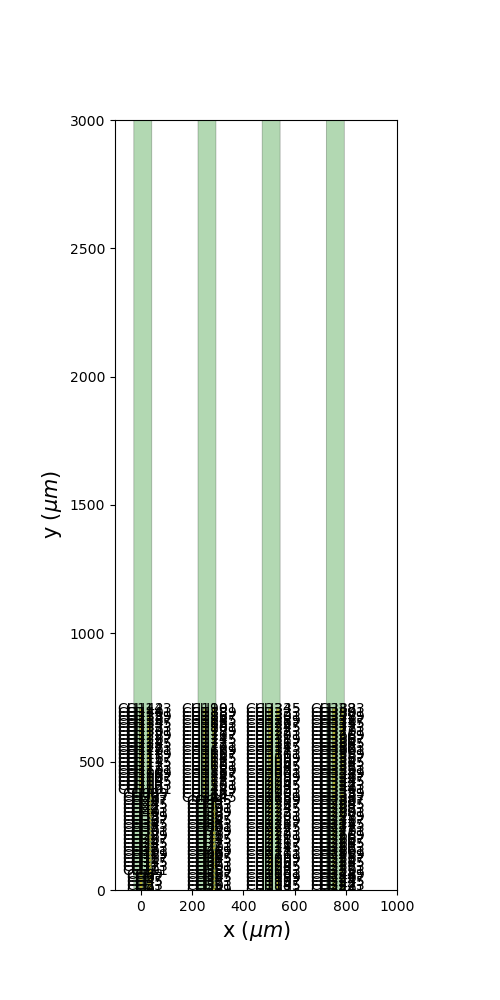

In [62]:
fig, ax = plt.subplots(figsize=(5, 10))
si.plot_probe_map(multirecording, ax=ax, with_channel_ids=True)
ax.set_ylim(00, 3000)
ax.set_xlim(-100, 1000)

## Preprocess the recording


In [63]:

rec1 = si.highpass_filter(multirecording, freq_min=400.)
# rec1 = si.bandpass_filter(multirecording,freq_min=400, freq_max=14000, filter_order=3, dtype="float32", add_reflect_padding=True)

bad_channel_ids, channel_labels = si.detect_bad_channels(rec1)

print('bad_channel_ids', bad_channel_ids)

bad_channel_ids ['CH19' 'CH21' 'CH45' 'CH102' 'CH103' 'CH117' 'CH119' 'CH123' 'CH143'
 'CH189' 'CH199']


In [64]:
len(bad_channel_ids)

11

In [65]:
rec2 = rec1.remove_channels(bad_channel_ids)
rec3 = si.phase_shift(rec2)
rec4 = si.common_reference(rec3, operator="median", reference="global")
rec4

CommonReferenceRecording: 373 channels - 30.0kHz - 1 segments - 12,287,779 samples 
                          409.59s (6.83 minutes) - int16 dtype - 8.54 GiB

## Visualize the preprocessing steps, Check noise level, and save
Interactive explore the preprocess steps could de done with this with the ipywydgets interactive ploter

In [69]:
%matplotlib widget
si.plot_traces({'raw':rec2 ,'cmr': rec4}, backend='ipywidgets',order_channel_by_depth=True)#,time_range=(1426.0,1426.1))

AppLayout(children=(TimeSlider(children=(Dropdown(description='segment', options=(0,), value=0), Button(icon='…

In [16]:
# plot some channels
#fig, ax = plt.subplots(figsize=(8, 10))
some_channels = [ 50, 100,150,200,250,300]
some_chans = rec.channel_ids[some_channels]
# si.plot_traces({'filter':rec3, 'cmr': rec}, backend='matplotlib', mode='line', ax=ax, channel_ids=some_chans)
# si.plot_traces({'cmr': rec}, backend='matplotlib', mode='line', ax=ax, time_range=(1426.0,1426.1))
# plt.savefig("traces.pdf", format="pdf", bbox_inches="tight")
si.plot_traces(rec4,mode= 'map', backend='matplotlib',order_channel_by_depth=True, time_range=(1507.1388,1508.1388))
plt.savefig(base_folder + "/cmr2.pdf", format="pdf")


NameError: name 'rec' is not defined

### Check noise level
A good practice before running a spike sorter is to checd noise  the presenc of driftt16) traces.

In [76]:

# we can estimate the noise on the scaled traces (microV) or on the raw one (which is in our case int16).
noise_levels_microV = si.get_noise_levels(rec4, return_scaled=True) # new version: noise_levels_microV = si.get_noise_levels(rec, return_in_uV=True)
noise_levels_int16 = si.get_noise_levels(rec4, return_scaled=False) # new:noise_levels_int16 = si.get_noise_levels(rec, return_in_uV=False)

noise_level (workers: 20 processes):   0%|          | 0/20 [00:00<?, ?it/s]

noise_level (workers: 20 processes):   0%|          | 0/20 [00:00<?, ?it/s]

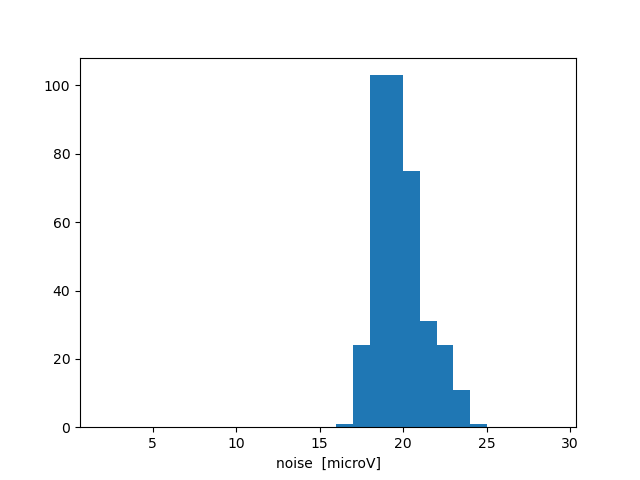

In [77]:
fig, ax = plt.subplots()
_ = ax.hist(noise_levels_microV, bins=np.arange(2, 30,1))
ax.set_xlabel('noise  [microV]')
plt.savefig(base_folder + "/noise_levels_microV.pdf", format="pdf")



### Save or load Preprocessed 

In [44]:
# rec = rec4
# rec = rec4.save(folder=base_folder + '/preprocess', format='binary', **job_kwargs)
# our recording now points to the new binary folder
# rec=si.load_extractor(base_folder + '/preprocess')
# rec
# rec4 = rec

## Check drift before spike sorting. We need to optimize it (it is under heavy development)  
#### The following will take lots of time

In [23]:
from spikeinterface.sortingcomponents.peak_detection import detect_peaks
from spikeinterface.sortingcomponents.peak_localization import localize_peaks

peaks = detect_peaks(rec4,  method='locally_exclusive', noise_levels=noise_levels_int16,
                     detect_threshold=5, radius_um=50., **job_kwargs)
# peaks
peak_locations = localize_peaks(rec4, peaks, method='center_of_mass', radius_um=50., **job_kwargs)

detect peaks using locally_exclusive (workers: 20 processes):   0%|          | 0/1112 [00:00<?, ?it/s]

localize peaks using center_of_mass (workers: 20 processes):   0%|          | 0/1112 [00:00<?, ?it/s]

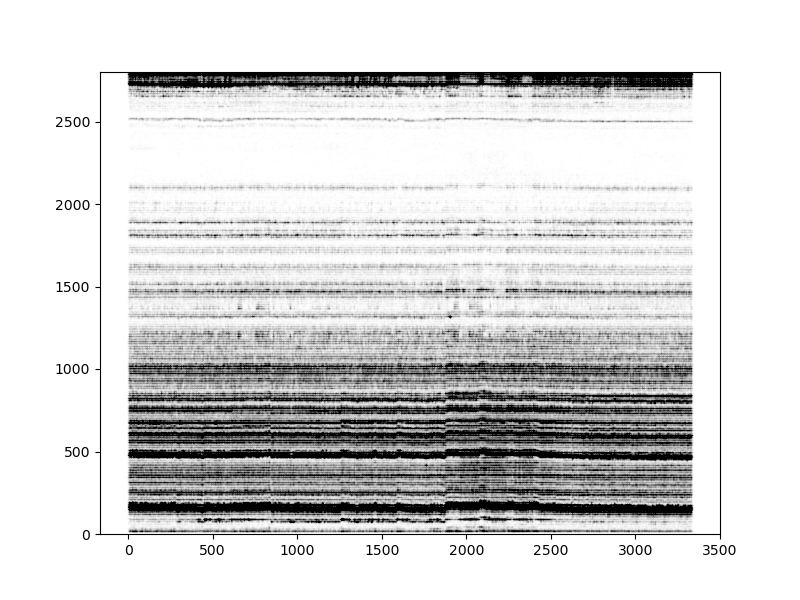

In [25]:
# check for drifts
fs = rec4.sampling_frequency
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(peaks['sample_index'] / fs, peak_locations['y'],s=2, color='k', marker='.',  alpha=0.002)
plt.ylim([0,2800])
plt.savefig("/drift9.pdf", format="pdf")


In [36]:
# #we can also use the peak location estimates to have an insight of cluster separation before sorting
# fig, (ax ,ax2) = plt.subplots(1,2,figsize=(10, 20))
# si.plot_probe_map(rec4, ax=ax, with_channel_ids=True)
# ax.set_ylim(-0, 1050)
# ax.set_xlim(-50, 150)
# ax.scatter(peak_locations['x'], peak_locations['y'], color='purple', alpha=0.002)


# si.plot_probe_map(rec4, ax=ax2, with_channel_ids=True)
# ax2.set_ylim(1050, 2100)
# ax2.set_xlim(200, 350)
# ax2.scatter(peak_locations['x'], peak_locations['y'], color='purple', alpha=0.002)

## Run a spike sorter

Important notes:

most of sorters are wrapped from external tools (kilosort, kisolort2.5, spykingcircus, montainsort4 …) that often also need other requirements (e.g., MATLAB, CUDA)

some sorters are internally developed (spyekingcircus2)

external sorter can be run inside a container (docker, singularity) WITHOUT pre-installation

In [37]:
# si.Kilosort2Sorter.set_kilosort2_path('E:\\mathwork\\analysis\\Kilosort-2.0.2')
# si.Kilosort3Sorter.set_kilosort3_path('E:\\mathwork\\analysis\\Kilosort-3.0.2')
# # check the installed Sorter list,

# from spikeinterface.sorters import installed_sorters
# installed_sorters()

In [24]:
# check default params for kilosort
si.get_default_sorter_params('kilosort4')

{'fs': 30000,
 'batch_size': 60000,
 'nblocks': 1,
 'Th_universal': 9,
 'Th_learned': 8,
 'nt': 61,
 'shift': None,
 'scale': None,
 'artifact_threshold': inf,
 'nskip': 25,
 'whitening_range': 32,
 'highpass_cutoff': 300,
 'binning_depth': 5,
 'sig_interp': 20,
 'drift_smoothing': [0.5, 0.5, 0.5],
 'nt0min': None,
 'dmin': None,
 'dminx': 32,
 'min_template_size': 10,
 'template_sizes': 5,
 'nearest_chans': 10,
 'nearest_templates': 100,
 'max_channel_distance': 32,
 'max_peels': 100,
 'templates_from_data': True,
 'n_templates': 6,
 'n_pcs': 6,
 'Th_single_ch': 6,
 'acg_threshold': 0.2,
 'ccg_threshold': 0.25,
 'cluster_downsampling': 20,
 'x_centers': None,
 'duplicate_spike_ms': 0.25,
 'position_limit': 100,
 'do_CAR': True,
 'invert_sign': False,
 'save_extra_vars': False,
 'save_preprocessed_copy': False,
 'torch_device': 'auto',
 'bad_channels': None,
 'clear_cache': False,
 'do_correction': True,
 'skip_kilosort_preprocessing': False,
 'keep_good_only': False,
 'use_binary_file

In [22]:
# params_kilosort= {'batch_size': 5000}
sorting = si.run_sorter('kilosort4', rec, output_folder=base_folder +'/KS4out',
                        docker_image=False,  verbose=True)#,**params_kilosort)

INFO:kilosort.run_kilosort: 
INFO:kilosort.run_kilosort:Computing preprocessing variables.
INFO:kilosort.run_kilosort:----------------------------------------
INFO:kilosort.run_kilosort:N samples: 67729189
INFO:kilosort.run_kilosort:N seconds: 2257.639633333333
INFO:kilosort.run_kilosort:N batches: 1129
INFO:kilosort.run_kilosort:Preprocessing filters computed in  5.44s; total  5.44s
INFO:kilosort.run_kilosort: 
INFO:kilosort.run_kilosort:Resource usage after preprocessing
INFO:kilosort.run_kilosort:********************************************************
INFO:kilosort.run_kilosort:CPU usage:    26.80 %
INFO:kilosort.run_kilosort:Memory:       10.19 %     |     19.43   /   190.65 GB
INFO:kilosort.run_kilosort:------------------------------------------------------
INFO:kilosort.run_kilosort:GPU usage:    `conda install pynvml` for GPU usage
INFO:kilosort.run_kilosort:GPU memory:   23.15 %     |      2.78   /    11.99 GB
INFO:kilosort.run_kilosort:Allocated:     0.07 %     |      0.01   

kilosort4 run time 3317.61s


In [6]:
## the results can be read back for futur session
sorting = si.read_sorter_folder(base_folder + '/KS4out')
sorting

KiloSortSortingExtractor: 223 units - 1 segments - 30.0kHz

# Post processing 

In [7]:
sorting2 = si.remove_excess_spikes(sorting, rec)

spike_vector = sorting.to_spike_vector()
spike_times_samples = spike_vector['sample_index']
print(spike_times_samples[:10]) # first x spike times

# remove duplicated spikes from the BaseSorting object
sorting2 = sc.remove_duplicated_spikes(sorting2, censored_period_ms=0.1)
sorting2


[  4  10  12  19  37 108 147 154 154 196]


RemoveDuplicatedSpikesSorting: 223 units - 1 segments - 30.0kHz

### Create sorting analyzer and remove duplicated units

In [50]:
analyzer = si.create_sorting_analyzer(sorting2, rec, sparse=True, format="memory",**job_kwargs)
analyzer

estimate_sparsity (workers: 32 processes):   0%|          | 0/324 [00:00<?, ?it/s]

SortingAnalyzer: 384 channels - 223 units - 1 segments - memory - sparse - has recording
Loaded 0 extensions

In [51]:
# analyzer.compute("random_spikes", method="uniform", max_spikes_per_unit=500)
# analyzer.compute("waveforms",  ms_before=1,ms_after=2, **job_kwargs)
# analyzer.compute("templates", operators=["average", "median", "std"])
# analyzer.compute("noise_levels")
# analyzer.compute("correlograms")
# analyzer.compute("spike_amplitudes", **job_kwargs)
# analyzer.compute("quality_metrics",**job_kwargs )
analyzer.compute(['noise_levels','random_spikes','waveforms','templates','spike_locations','spike_amplitudes','correlograms','principal_components','quality_metrics','template_metrics'],**job_kwargs)
analyzer.compute('template_metrics', include_multi_channel_metrics=True,**job_kwargs)
analyzer.compute("unit_locations",**job_kwargs)
analyzer.compute("template_similarity",**job_kwargs)
# analyzer.compute('principal_components', n_components = 5, mode="by_channel_local")


analyzer


noise_level (workers: 20 processes):   0%|          | 0/20 [00:00<?, ?it/s]

compute_waveforms (workers: 32 processes):   0%|          | 0/324 [00:00<?, ?it/s]

Fitting PCA:   0%|          | 0/223 [00:00<?, ?it/s]

Projecting waveforms:   0%|          | 0/223 [00:00<?, ?it/s]

Compute : spike_locations + spike_amplitudes (workers: 32 processes):   0%|          | 0/324 [00:00<?, ?it/s]

noise_level (no parallelization):   0%|          | 0/20 [00:00<?, ?it/s]

calculate_pc_metrics:   0%|          | 0/223 [00:00<?, ?it/s]

SortingAnalyzer: 384 channels - 223 units - 1 segments - memory - sparse - has recording
Loaded 12 extensions: noise_levels, random_spikes, waveforms, templates, correlograms, principal_components, template_metrics, spike_locations, spike_amplitudes, quality_metrics, unit_locations, template_similarity

In [52]:
# Remove redundant units from the Sorting Analyzer object
# Note this returns a cleaned sorting
clean_sorting = sc.remove_redundant_units(
    analyzer,
    duplicate_threshold=0.95,
    remove_strategy="minimum_shift"
)
# To have a SortingAnalyzer with only the non-redundant units, one must
# select the designed units, remembering to give the format and folder if one wants
# a persistent SortingAnalyzer.
analyzer = analyzer.select_units(clean_sorting.unit_ids)
analyzer

SortingAnalyzer: 384 channels - 223 units - 1 segments - memory - sparse - has recording
Loaded 12 extensions: noise_levels, random_spikes, waveforms, templates, correlograms, principal_components, template_metrics, spike_locations, spike_amplitudes, unit_locations, template_similarity, quality_metrics

#### We can save the analyzer or load them

In [8]:
# analyzer_saved = analyzer.save_as(folder=base_folder + "/analyzer", format="binary_folder")
# analyzer_saved


analyzer = si.load_sorting_analyzer(folder=base_folder +"/analyzer") # start from a sorting_analyzer
analyzer

SortingAnalyzer: 384 channels - 223 units - 1 segments - binary_folder - sparse - has recording
Loaded 12 extensions: correlograms, noise_levels, principal_components, quality_metrics, random_spikes, spike_amplitudes, spike_locations, templates, template_metrics, template_similarity, unit_locations, waveforms

## Apply AI Model to label clusters

In [6]:
# Apply the noise/not-noise model
noise_neuron_labels = sc.auto_label_units(
    sorting_analyzer=analyzer,
    repo_id="SpikeInterface/UnitRefine_noise_neural_classifier",
    trust_model=True,
)


noise_units = noise_neuron_labels[noise_neuron_labels['prediction']=='noise']
analyzer_neural = analyzer.remove_units(noise_units.index)

# Apply the sua/mua model
sua_mua_labels = sc.auto_label_units(
    sorting_analyzer=analyzer_neural,
    repo_id="SpikeInterface/UnitRefine_sua_mua_classifier",
    trust_model=True,
)

AI_labels = pd.concat([sua_mua_labels, noise_units]).sort_index()
AI_labels

,prediction,probability
0,mua,0.773462
1,mua,0.737097
2,noise,0.901524
3,mua,0.642717
4,mua,0.821467
...,...,...
218,noise,0.723953
219,noise,0.954082
220,noise,0.579400
221,noise,0.931101


#### Export the data for phy

In [7]:
df_prob = AI_labels[["probability"]].rename(columns={"probability": "AI_prob"})
df_prob = df_prob.reset_index()

df_prob

,index,AI_prob
0,0,0.773462
1,1,0.737097
2,2,0.901524
3,3,0.642717
4,4,0.821467
...,...,...
218,218,0.723953
219,219,0.954082
220,220,0.579400
221,221,0.931101


In [9]:
si.export_to_phy(analyzer, output_folder=base_folder + '/ks4phy', 
                 compute_amplitudes=True, compute_pc_features=False, copy_binary=False,
                 **job_kwargs)

# Save model labels along with the exporter data as a TSV file (phy will open them by default)

AI_labels.index.name ='cluster_id'

# Create a DataFrame for the AI probabilities.
# We extract the 'probability' column and rename it to 'AI_prob'.
df_prob = AI_labels[["probability"]].rename(columns={"probability": "AI_prob"})
df_prob = df_prob.reset_index()
df_prob.to_csv(base_folder + '/ks4phy/cluster_AIprob.tsv', sep="\t", index=False)
# same for the predictions
df_labels = AI_labels[["prediction"]].rename(columns={"prediction": "AI_label"})
df_labels = df_labels.reset_index()
df_labels.to_csv(base_folder + '/ks4phy/cluster_AIlabels.tsv', sep='\t',index=False)


Run:
phy template-gui  D:\ephys\R004-DB36D\2025-02-18\ks4phy\params.py


## Autommated curation

In [10]:
print(si.get_quality_metric_list())
print(si.get_quality_pca_metric_list())

['num_spikes', 'firing_rate', 'presence_ratio', 'snr', 'isi_violation', 'rp_violation', 'sliding_rp_violation', 'amplitude_cutoff', 'amplitude_median', 'amplitude_cv', 'synchrony', 'firing_range', 'drift', 'sd_ratio', 'noise_cutoff']
['isolation_distance', 'l_ratio', 'd_prime', 'nearest_neighbor', 'nn_isolation', 'nn_noise_overlap', 'silhouette']


In [11]:

qm_ext = analyzer.get_extension("quality_metrics")
metrics = qm_ext.get_data()
metrics = metrics.join(AI_labels, how='right')
metrics

,num_spikes,firing_rate,presence_ratio,snr,isi_violations_ratio,isi_violations_count,rp_contamination,rp_violations,sliding_rp_violation,amplitude_cutoff,...,noise_cutoff,noise_ratio,isolation_distance,l_ratio,d_prime,silhouette,nn_hit_rate,nn_miss_rate,prediction,probability
cluster_id,,,,,,,,,,,,,,,,,,,,,
0,165343,102.235572,1.000000,0.661603,0.702795,35640.0,1.000000,25457.0,NaN,0.000002,...,-0.194842,0.005220,87.563800,0.761674,2.567161,0.010737,0.153384,0.035056,mua,0.773462
1,169302,104.683517,1.000000,1.180698,0.674279,35851.0,1.000000,25507.0,NaN,0.020119,...,0.559647,0.039978,76.448383,0.797926,2.355160,0.013182,0.185500,0.073465,mua,0.737097
2,42329,26.173043,1.000000,0.204614,2.048961,6810.0,1.000000,5142.0,NaN,0.000084,...,-0.259873,0.011301,120.999379,1.969744,1.916566,0.004023,0.113500,0.014794,noise,0.901524
3,48932,30.255838,1.000000,3.269000,0.067546,300.0,0.050232,145.0,0.05,0.000116,...,-0.498923,0.045786,78.162762,1.830070,2.553383,0.103933,0.443231,0.013912,mua,0.642717
4,51497,31.841839,1.000000,1.877995,1.446147,7114.0,1.000000,5130.0,NaN,0.002364,...,0.474581,0.034824,72.821538,0.984298,2.017922,0.013457,0.188000,0.071335,mua,0.821467
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218,870,0.537942,1.000000,1.491446,2.136709,3.0,1.000000,2.0,NaN,0.000300,...,-0.099805,0.091880,142.529241,0.210411,4.195190,0.176459,0.826500,0.001000,noise,0.723953
219,502,0.310399,0.576923,0.958224,188.251206,88.0,1.000000,8.0,NaN,0.000888,...,-0.005967,0.029249,55.794288,6.968251,1.862857,0.028320,0.136667,0.004779,noise,0.954082
220,430,0.265879,0.730769,1.188204,34.987013,12.0,1.000000,9.0,NaN,NaN,...,6.924479,0.014610,102.735435,4.490206,1.628226,0.037182,0.113095,0.004854,noise,0.579400


In [12]:
# %matplotlib widget
# sparsity = si.compute_sparsity(analyzer, method = "radius", radius_um = 30) 
# w = si.plot_unit_templates(analyzer,templates_percentile_shading=None,backend = "ipywidgets")

In [13]:
# si.plot_quality_metrics(analyzer, include_metrics=["amplitude_cutoff", "isi_violations_ratio", "snr"], 
#                         backend="ipywidgets")

In [14]:
# first remove noise detected by the model with high confidence
noise_conf_thresh = 0.8
metrics = metrics.loc[
    ~((AI_labels['prediction'] == 'noise') & (AI_labels['probability'] > noise_conf_thresh))
]


In [15]:
# remove some more with a hard threshold on metrics
isi_viol_thresh = 0.4
amp_cutoff_thresh = 0.2
snr_thresh = 2
our_query = f"amplitude_cutoff < {amp_cutoff_thresh} & isi_violations_ratio < {isi_viol_thresh} & snr > {snr_thresh}"
print(our_query)

amplitude_cutoff < 0.2 & isi_violations_ratio < 0.4 & snr > 2


In [16]:
keep_units = metrics.query(our_query)
keep_unit_ids = keep_units.index.values
# keep_units

In [22]:
Auto_curated = analyzer.select_units(keep_unit_ids, folder=base_folder + "/waveforms_curated")
Auto_curated

SortingAnalyzer: 384 channels - 70 units - 1 segments - memory - sparse - has recording
Loaded 12 extensions: correlograms, noise_levels, random_spikes, waveforms, principal_components, templates, spike_amplitudes, spike_locations, template_metrics, template_similarity, unit_locations, quality_metrics

In [23]:
print(f"Number of units before curation: {len(analyzer.sorting.get_unit_ids())}")
print(f"Number of units after curation: {len(Auto_curated.sorting.get_unit_ids())}")

Number of units before curation: 223
Number of units after curation: 70


In [67]:
# %matplotlib widget
# si.plot_quality_metrics(Auto_curated, include_metrics=["amplitude_cutoff", "isi_violations_ratio", "snr"], 
#                         backend="ipywidgets")

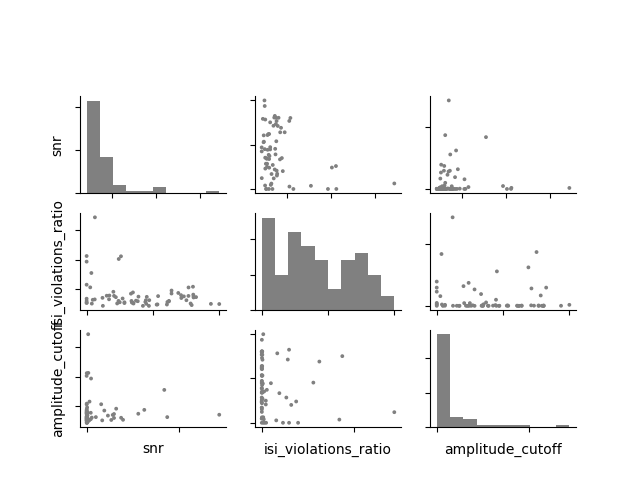

In [68]:
si.plot_quality_metrics(Auto_curated, include_metrics=["amplitude_cutoff", "isi_violations_ratio", "snr"], 
                        backend="matplotlib")

plt.savefig(base_folder + "/qm.pdf", format="pdf")


In [24]:
si.export_to_phy(Auto_curated, output_folder=base_folder + '/ks4phy_autocurated', 
                 compute_amplitudes=True, compute_pc_features=False, copy_binary=False,
                 **job_kwargs)

AI_labels2 = AI_labels.loc[AI_labels.index.isin(keep_unit_ids)]

# Create a DataFrame for the AI probabilities.
# We extract the 'probability' column and rename it to 'AI_prob'.
df_prob = AI_labels2[["probability"]].rename(columns={"probability": "AI_prob"})
df_prob = df_prob.reset_index()
df_prob.to_csv(base_folder + '/ks4phy_autocurated/cluster_AIprob.tsv', sep="\t", index=False)
# same for the predictions
df_labels = AI_labels2[["prediction"]].rename(columns={"prediction": "AI_label"})
df_labels = df_labels.reset_index()
df_labels.to_csv(base_folder + '/ks4phy_autocurated/cluster_AIlabels.tsv', sep='\t',index=False)


Run:
phy template-gui  D:\ephys\R004-DB36D\2025-02-18\ks4phy_autocurated\params.py


In [71]:
df_labels

,cluster_id,AI_label
0,3,mua
1,5,mua
2,6,mua
3,8,mua
4,9,sua
...,...,...
65,203,mua
66,206,mua
67,212,sua
68,216,mua


In [25]:
rec_subfolders

['D:\\ephys\\R004-DB36D\\2025-02-18\\2025-02-18_23-14-30',
 'D:\\ephys\\R004-DB36D\\2025-02-18\\2025-02-18_23-41-42',
 'D:\\ephys\\R004-DB36D\\2025-02-18\\2025-02-18_23-51-03']

### save some data regarding the recording

#### lets first get the recording date

In [27]:
def find_file(directory, filename):
    for root, dirs, files in os.walk(directory):
        if filename in files:
            return os.path.join(root, filename)
    return None

file_name = "settings.xml"
# rec_subfolders[0]
# Find the file
file_path = find_file(rec_subfolders[0], file_name)

if file_path:
    # Get the file creation date
    # creation_time = os.path.getctime(file_path)
    # creation_date = datetime.datetime.fromtimestamp(creation_time).date()
    modification_time = os.path.getmtime(file_path)
    modification_time = datetime.datetime.fromtimestamp(modification_time).date()


    print(f"Recording date: {modification_time}")
else:
    print(f"File '{file_name}' not found in '{rec_subfolder}'")
    
# Example DataFrame
rec_df = pd.DataFrame({
    'rec_date': modification_time,
    'mean_chan_noise': np.mean(noise_levels_microV),
    'chan_locX': [min(probe_df.x)],
    'chan_locY': [min(probe_df.y)]

})

# Save to a CSV file
rec_df.to_csv(base_folder + '/rec_info.csv', index=False)


Recording date: 2025-02-18


NameError: name 'noise_levels_microV' is not defined

# Spike data analysis
### To analyze the spike data we first need to get stimulus onsets and ofsets
They are usually stored in the ADC channels of OpenEphys or the as ttl Events.
In case of ONIX data recorded in Bnsial or openEphys other methods may eb needed


In [104]:
ADC_list = []
TTL_list = []
for Dir in rec_subfolders:
    ADC_list.append( si.read_openephys(Dir,stream_id='2',load_sync_timestamps=True)) # chack the number of channels in the  data stream
    TTL_list.append(si.read_openephys_event(Dir))
 
ADC_list

[OpenEphysBinaryRecordingExtractor: 8 channels - 30.0kHz - 1 segments - 20,110,848 samples 
                                    670.36s (11.17 minutes) - int16 dtype - 306.87 MiB,
 OpenEphysBinaryRecordingExtractor: 8 channels - 30.0kHz - 1 segments - 10,731,520 samples 
                                    357.72s (5.96 minutes) - int16 dtype - 163.75 MiB,
 OpenEphysBinaryRecordingExtractor: 8 channels - 30.0kHz - 1 segments - 17,675,264 samples 
                                    589.18s (9.82 minutes) - int16 dtype - 269.70 MiB]

### Extracting TTL Events from Rhythm FPGA TTL Input 
#### Steps:
- **Access the TTL event extractor** from the session object.
- **Retrieve channel IDs** associated with TTL inputs.
- **Get the session duration** from the ADC (analog-to-digital converter).
- **Extract structured TTL events** from a specific channel.
- **Access individual fields**: time, duration, and label.
- **Print summary information** about the session and events.

### Understanding TTL Labels from Rhythm FPGA TTL Input
Each TTL event label is a string representation of an integer, where each **bit** corresponds to one of the 8 digital channels. The label acts as a **bitmask**, indicating which channels were active during the event. Example TTL Bitmask Table. Use this table to decode TTL labels and determine which digital inputs were triggered during each event.
| Decimal Label | Binary Value | Active Channels |
|---------------|--------------|------------------|
| 1             | `00000001`   | Channel 1        |
| 2             | `00000010`   | Channel 2        |
| 3             | `00000011`   | Channels 1 & 2   |
| 4             | `00000100`   | Channel 3        |
| 5             | `00000101`   | Channels 1 & 3   |
| 8             | `00001000`   | Channel 4        |
| 16            | `00010000`   | Channel 5        |
| 32            | `00100000`   | Channel 6        |
| 64            | `01000000`   | Channel 7        |
| 128           | `10000000`   | Channel 8        |

In [105]:
events = TTL_list[0]
channel_ids = TTL_list[0].channel_ids
print('channel ids = ',channel_ids)

# Initialize empty lists to collect data across sessions
all_times = []
all_durations = []
all_labels = []
offset = 0
# Loop through each TTL event extractor in TT_events
for session_index, events in enumerate(TTL_list):
    print(f"Processing session {session_index}...")
    sess_duration = ADC_list[session_index].get_total_duration()
    print('session duration=',sess_duration)
    channel_ids = events.channel_ids
    # Get events from the first TTL channel
    Rhythm_events = events.get_events(channel_id=channel_ids[0])
    print('first time stamp=',Rhythm_events[0])
    print('last time stamp=',Rhythm_events[-1])
    # Extract structured fields
    Times = Rhythm_events['time']  + offset
    print('corrected first time stamp=',Times[0])
    print('corrected last time stamp=',Times[-1])
    durations = Rhythm_events['duration']
    labels = Rhythm_events['label']
    
    # Append to master lists
    all_times.append(Times)
    all_durations.append(durations)
    all_labels.append(labels)
    offset += duration

# Concatenate across all sessions
all_times = np.concatenate(all_times)
all_durations = np.concatenate(all_durations)
all_labels = np.concatenate(all_labels)


channel ids =  ['Rhythm FPGA TTL Input' 'Messages' 'Neuropixels PXI Sync']
Processing session 0...
session duration= 670.3616000000001
first time stamp= (1.5, 0.5, '3')
last time stamp= (670.49974365, 0.50000003, '3')
corrected first time stamp= 1.5
corrected last time stamp= 670.4997436523271
Processing session 1...
session duration= 357.71733333333333
first time stamp= (23.0464, 0.5, '3')
last time stamp= (379.0462, 0.5, '3')
corrected first time stamp= 693.408
corrected last time stamp= 1049.4078
Processing session 2...
session duration= 589.1754666666667
first time stamp= (4., 0.5, '3')
last time stamp= (591.99959479, 0.49999997, '3')
corrected first time stamp= 1344.7232000000001
corrected last time stamp= 1932.722794791693


#### Python Snippet to Decode Active Channels
 To determine which digital inputs were triggered during each event
<h4 style="background-color:yellow"><strong>👇 This must be checked on the actual event times on different channels.</strong></h4>


In [106]:
def decode_active_channels(label_str):
    label_int = int(label_str)
    return [i + 1 for i in range(8) if (label_int >> i) & 1]

# Decode all labels
decoded_channels = [decode_active_channels(label) for label in labels]

# Print first few decoded events
for i in range(5):
    print(f"Time: {times[i]:.3f}s, Label: {labels[i]}, Active Channels: {decoded_channels[i]}")


Time: 4.000s, Label: 3, Active Channels: [1, 2]
Time: 5.000s, Label: 3, Active Channels: [1, 2]
Time: 6.000s, Label: 3, Active Channels: [1, 2]
Time: 7.000s, Label: 3, Active Channels: [1, 2]
Time: 8.000s, Label: 3, Active Channels: [1, 2]


### Extracting Events from Rhythm FPGA ADC Input 
#### Steps:
- **concatenate_recordings** from the session object.
- **get raising and falling edges** associated with Analog inputs.
- **Get the session duration** from the ADC (analog-to-digital converter).

In [107]:
# The `concatenate_recordings()` mimics a mono-segment object that concatenates all segments
multiADC = si.concatenate_recordings(ADC_list)
multiADC

ConcatenateSegmentRecording: 8 channels - 30.0kHz - 1 segments - 48,517,632 samples 
                             1,617.25s (26.95 minutes) - int16 dtype - 740.32 MiB

In [119]:
## gaussian_filter()
# highpass
# multiADC_hp = gaussian_filter(recording=multiADC_lp, freq_min=300, freq_max=None)
# lowpass
multiADC_lp = si.gaussian_filter(recording=multiADC, freq_min=None, freq_max=500)
# bandpass
# multiADC_bp = gaussian_filter(recording=multiADC, freq_min=300, freq_max=2000)

# Downsample to 1000 Hz
multiADC_downsampled = si.resample(
    recording=multiADC_lp,
    resample_rate=3000,           # Target sampling frequency
    margin_ms=100.0,              # Optional: helps reduce edge artifacts
    dtype=None,                   # Optional: inherits original dtype
    skip_checks=False             # Optional: performs safety checks
)

In [120]:

%matplotlib widget
si.plot_traces({'raw':multiADC ,'lowpass': multiADC_lp,'downsamples':multiADC_downsampled}, backend='ipywidgets',show_channel_ids=True)#,time_range=(1426.0,1426.1))

AppLayout(children=(TimeSlider(children=(Dropdown(description='segment', options=(0,), value=0), Button(icon='…

In [164]:
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
import numpy as np

def plot_edges_slider(normalized_traces, rec_times, edge_indices, window_size, edge_label='Edges', edge_color='r'):
    """
    Plots normalized traces with specified edges and a slider to scroll through time.

    Parameters:
    - normalized_traces: 1D numpy array of normalized signal values
    - rec_times: 1D numpy array of timestamps
    - edge_indices: 1D numpy array of indices where edges occur (rising, falling, etc.)
    - window_size: int, number of samples per window
    - edge_label: str, label for the edge markers (default: 'Edges')
    - edge_color: str, color for edge markers (default: 'r' for red)
    """
    start_index = 0
    end_index = start_index + window_size

    x_init = rec_times[start_index:end_index]
    y_init = normalized_traces[start_index:end_index]
    edges_init = edge_indices[(edge_indices >= start_index) & (edge_indices < end_index)]

    fig, ax = plt.subplots(figsize=(6, 4))
    plt.subplots_adjust(bottom=0.25)

    trace_line, = ax.plot(x_init, y_init, label='Normalized Trace')
    edge_line, = ax.plot(rec_times[edges_init], normalized_traces[edges_init], f'{edge_color}*', label=edge_label)

    ax.set_title(f'{edge_label} Detection')
    ax.set_xlabel('Time')
    ax.set_ylabel('Normalized Signal')
    ax.set_ylim([0, 1.5])
    ax.legend(loc='upper left')

    ax_slider = plt.axes([0.2, 0.1, 0.6, 0.03])
    slider = Slider(ax_slider, 'Start Index', 0, len(rec_times) - window_size, valinit=start_index, valstep=1)

    def update(val):
        idx = int(slider.val)
        x = rec_times[idx:idx + window_size]
        y = normalized_traces[idx:idx + window_size]
        edges = edge_indices[(edge_indices >= idx) & (edge_indices < idx + window_size)]

        trace_line.set_data(x, y)
        edge_line.set_data(rec_times[edges], normalized_traces[edges])
        ax.set_xlim(x[0], x[-1])
        ax.set_ylim([0, 1.5])
        fig.canvas.draw_idle()

    slider.on_changed(update)
    plt.show()


In [172]:

start = time.time()


# Get traces from ADC channel (e.g., channel index 'ADC1''ADC2'....'ADC8')
recording2 = multiADC_downsampled
traces = recording2.get_traces(channel_ids=['ADC2'])
print(max(traces))
rec_times = recording2.get_times()

# Min-max normalization
traces_min = np.min(traces)
traces_max = np.max(traces)
normalized_traces = (traces - traces_min) / (traces_max - traces_min)
print(max(normalized_traces))

# Simple threshold-based edge detection
threshold = 0.5
rising_edges = np.where((normalized_traces[:-1] < threshold) & (normalized_traces[1:] >= threshold))[0]
falling_edges = np.where((normalized_traces[:-1] > threshold) & (normalized_traces[1:] <= threshold))[0]

end = time.time()

print(f"Runtime: {end - start:.4f} seconds")

[29830]
[1.]
Runtime: 29.0519 seconds


In [178]:
start = time.time()

# Define the ADC channels and their roles
adc_channels = {
    'ADC1': 'camera_output',
    'ADC2': 'coil_stimulation',
    'ADC3': 'other_stimulation',
    # Add more channels here as needed
}

# Threshold for edge detection
threshold = 0.5

# Dictionary to store edge events per channel
sync_events = {}

for adc_name, role in adc_channels.items():
    print(f"\nProcessing {adc_name} ({role})")

    # Get traces and timestamps
    traces = multiADC_downsampled.get_traces(channel_ids=[adc_name])
    rec_times = multiADC_downsampled.get_times()

    # Normalize
    traces_min = np.min(traces)
    traces_max = np.max(traces)
    normalized_traces = (traces - traces_min) / (traces_max - traces_min)

    # Edge detection
    rising_edges = np.where((normalized_traces[:-1] < threshold) & (normalized_traces[1:] >= threshold))[0]
    falling_edges = np.where((normalized_traces[:-1] > threshold) & (normalized_traces[1:] <= threshold))[0]

    # Store everything needed for plotting and alignment
    sync_events[adc_name] = {
        'role': role,
        'rising_edges': rising_edges,
        'falling_edges': falling_edges,
        'normalized_traces': normalized_traces,
        'rec_times': rec_times
    }
end = time.time()
print(f"\nTotal Runtime: {end - start:.4f} seconds")



Processing ADC1 (camera_output)

Processing ADC2 (coil_stimulation)

Processing ADC3 (other_stimulation)

Total Runtime: 72.9426 seconds


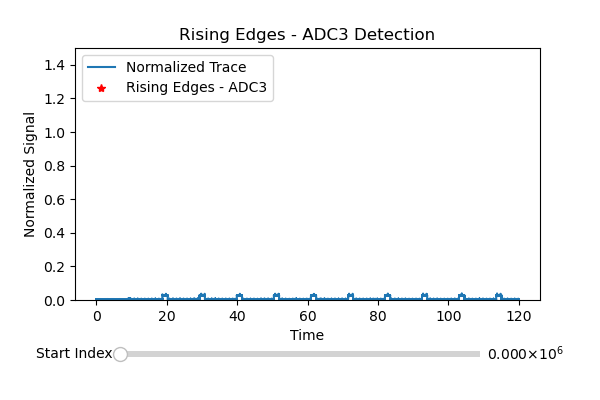

In [185]:
%matplotlib widget

channel_to_plot = 'ADC3'  # Change to 'ADC1', 'ADC3', etc.
plot_edges_slider(
    sync_events[channel_to_plot]['normalized_traces'],
    sync_events[channel_to_plot]['rec_times'],
    sync_events[channel_to_plot]['rising_edges'],
    window_size=120*3000,
    edge_label=f"Rising Edges - {channel_to_plot}",
    edge_color='r'
)


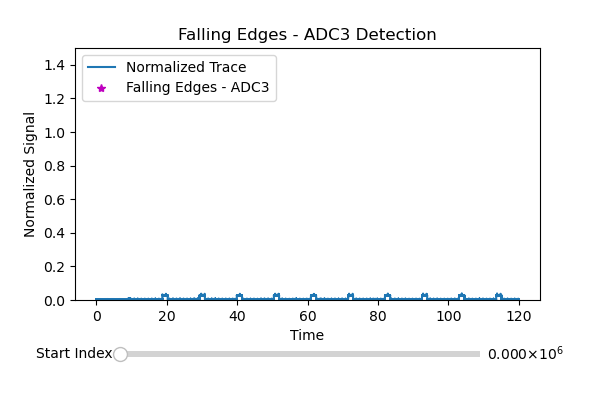

In [188]:
# check the detected edges
%matplotlib widget
# For falling edges
# plot_edges_slider(normalized_traces, rec_times, falling_edges, window_size=60*30000, edge_label='Falling Edges', edge_color='m')
channel_to_plot = 'ADC3'  # Change to 'ADC1', 'ADC3', etc.
plot_edges_slider(
    sync_events[channel_to_plot]['normalized_traces'],
    sync_events[channel_to_plot]['rec_times'],
    sync_events[channel_to_plot]['falling_edges'],
    window_size=120*3000,
    edge_label=f"Falling Edges - {channel_to_plot}",
    edge_color='m'
)


### 🧪 Spike Alignment and Visualization

In this analysis, we examine neuronal responses to stimuli recorded via ADC channels. The procedure involves:

1. **Spike Alignment**: For each neuron, spike times are aligned relative to each stimulus event within a defined time window (e.g., -100 ms to +300 ms).
2. **Raster Plot**: Visualize individual spike occurrences across trials to assess temporal firing patterns.
3. **Peri-Stimulus Time Histogram (PSTH)**: Aggregate spike counts across trials into time bins to quantify average firing rate changes around stimulus onset.

This approach helps identify stimulus-locked neural activity and characterize response dynamics across units.


In [192]:
def get_aligned_spike_times(analyzer, unit_ids, event_times, window=(-0.1, 0.3)):
    """
    Aligns spike times to stimulus events for raster/PSTH plotting.

    Parameters:
    - analyzer: SpikeInterface SortingAnalyzer object
    - unit_ids: list of unit IDs to include
    - event_times: array of stimulus onset times (in seconds)
    - window: tuple (start, end) in seconds around each event

    Returns:
    - aligned_spikes: dict {unit_id: list of arrays of aligned spike times per event}
    """
    aligned_spikes = {}

    for unit_id in unit_ids:
        spike_times = analyzer.get_unit_spike_train(unit_id=unit_id, segment_index=0)
        aligned = []

        for t_event in event_times:
            # Get spikes within the window around the event
            mask = (spike_times >= t_event + window[0]) & (spike_times <= t_event + window[1])
            aligned_times = spike_times[mask] - t_event
            aligned.append(aligned_times)

        aligned_spikes[unit_id] = aligned

    return aligned_spikes


In [193]:
def plot_raster_and_psth(aligned_spikes, window=(-0.1, 0.3), bin_size=0.01):
    """
    Plots raster and PSTH for aligned spike data.

    Parameters:
    - aligned_spikes: dict {unit_id: list of arrays of aligned spike times}
    - window: tuple (start, end) in seconds
    - bin_size: float, bin width for PSTH
    """
    fig, (ax_raster, ax_psth) = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

    # Raster plot
    trial_idx = 0
    for unit_id, trials in aligned_spikes.items():
        for trial_spikes in trials:
            ax_raster.vlines(trial_spikes, trial_idx, trial_idx + 0.8)
            trial_idx += 1
    ax_raster.set_ylabel("Trials")
    ax_raster.set_title("Raster Plot")

    # PSTH
    all_spikes = np.concatenate([spike for trials in aligned_spikes.values() for spike in trials])
    bins = np.arange(window[0], window[1] + bin_size, bin_size)
    counts, _ = np.histogram(all_spikes, bins=bins)
    ax_psth.bar(bins[:-1], counts, width=bin_size, align='edge')
    ax_psth.set_ylabel("Spike Count")
    ax_psth.set_xlabel("Time (s)")
    ax_psth.set_title("Peri-Stimulus Time Histogram (PSTH)")

    plt.tight_layout()
    plt.show()


In [194]:
stim_times = sync_events['ADC2']['rising_edges']  # or any other ADC channel
unit_ids = Auto_curated.sorting.get_unit_ids()

aligned = get_aligned_spike_times(Auto_curated, unit_ids, stim_times, window=(-0.1, 0.3))
plot_raster_and_psth(aligned, window=(-0.1, 0.3), bin_size=0.01)


AttributeError: 'SortingAnalyzer' object has no attribute 'get_unit_spike_train'